In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import glob

# Set your directory path
data_dir = "/explore/nobackup/projects/pix4dcloud/jacaraba/tiles_pix4d/1-metadata/convection/"

def reconstruct_storms_correctly_and_fast(data_dir):
    """
    Correct and efficient storm reconstruction
    This function processes storm tracking data to correctly identify multi-day storms
    by linking consecutive daily storm records that represent the same storm system.
    """
    
    # Step 1: Find and load all storm data files
    lifetime_files = glob.glob(os.path.join(data_dir, "*_cloudsystems_lifetimes.csv"))
    
    all_daily_data = []  # Will store all daily storm records
    
    print(f"Processing {len(lifetime_files)} files...")
    
    # Loop through each daily file and load the data
    for i, lifetime_file in enumerate(lifetime_files):
        try:
            # Extract date from filename (assumes format: YYYYMMDD_cloudsystems_lifetimes.csv)
            filename = os.path.basename(lifetime_file)
            date_str = filename.split('_')[0]
            
            # Read the lifetime data (contains start/end times, durations)
            df_lifetimes = pd.read_csv(lifetime_file)
            
            # Find corresponding metadata file (contains lat/lon, center coordinates)
            metadata_file = lifetime_file.replace('lifetimes.csv', 'metadata.csv')
            
            if os.path.exists(metadata_file):
                df_metadata = pd.read_csv(metadata_file)
                
                # Convert time strings to datetime objects for proper time handling
                df_lifetimes['start_datetime'] = pd.to_datetime(df_lifetimes['start_time'])
                df_lifetimes['end_datetime'] = pd.to_datetime(df_lifetimes['end_time'])
                df_lifetimes['date_int'] = int(date_str)  # Store date as integer for sorting
                
                # Merge lifetime and metadata on system_id
                df_combined = pd.merge(df_lifetimes, df_metadata, on='system_id', how='inner')
                all_daily_data.append(df_combined)
                
            # Progress reporting every 100 files
            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{len(lifetime_files)} files...")
                
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    # Step 2: Combine all daily data and prepare for analysis
    all_data = pd.concat(all_daily_data, ignore_index=True)
    print(f"✓ Read {len(all_data)} daily records")
    
    print("Reconstructing storms correctly...")
    
    # Sort by system_id and date for proper sequential processing
    all_data = all_data.sort_values(['system_id', 'date_int']).reset_index(drop=True)
    
    # Step 3: Identify which systems appear on single vs multiple days
    system_day_counts = all_data.groupby('system_id')['date_int'].nunique()
    
    # Systems that appear on only one day (definitely single-day storms)
    single_day_systems = system_day_counts[system_day_counts == 1].index
    
    # Systems that appear on multiple days (might be multi-day storms)
    multi_day_candidates = system_day_counts[system_day_counts > 1].index
    
    print(f"  Single-day systems: {len(single_day_systems):,}")
    print(f"  Multi-day candidates: {len(multi_day_candidates):,}")
    
    # Step 4: Process the simple case - storms that only appear on one day
    single_day_data = all_data[all_data['system_id'].isin(single_day_systems)].copy()
    single_day_data['true_start_datetime'] = single_day_data['start_datetime']
    single_day_data['true_end_datetime'] = single_day_data['end_datetime'] 
    single_day_data['true_duration_min'] = single_day_data['duration_min']
    single_day_data['num_days'] = 1
    single_day_data['is_multi_day'] = False
    single_day_data['storm_id'] = single_day_data['system_id'].astype(str) + '_single'
    
    # Step 5: Process the complex case - systems that appear on multiple days
    multi_day_data = all_data[all_data['system_id'].isin(multi_day_candidates)].copy()
    
    if len(multi_day_data) > 0:
        print("  Processing multi-day candidates...")
        
        # Step 5a: Identify consecutive day patterns
        # For each record, get the previous record's system_id and date
        multi_day_data['prev_system'] = multi_day_data['system_id'].shift(1)
        multi_day_data['prev_date'] = multi_day_data['date_int'].shift(1)
        
        # A new storm group starts when we see a new system_id or there's a gap in dates
        multi_day_data['new_consecutive_group'] = (
            (multi_day_data['system_id'] != multi_day_data['prev_system']) |
            ((multi_day_data['system_id'] == multi_day_data['prev_system']) & 
             (multi_day_data['date_int'] - multi_day_data['prev_date'] > 1))
        )
        
        # Give each consecutive group a unique ID
        multi_day_data['temp_group'] = multi_day_data['new_consecutive_group'].cumsum()
        
        # Step 5b: Combine consecutive day groups into single storm records
        multi_day_storms = multi_day_data.groupby('temp_group').agg({
            'system_id': 'first',              # Keep the system_id
            'start_datetime': 'min',           # Earliest start time
            'end_datetime': 'max',             # Latest end time  
            'duration_min': 'sum',             # Sum of daily durations
            'num_time_steps': 'sum',           # Sum of time steps
            'date_int': ['count', 'first'],    # count=num_days, first=start_date
            'center_y': 'first',               # Keep location info from first day
            'center_x': 'first',
            'latitude': 'first',
            'longitude': 'first'
        }).reset_index()
        
        # Clean up the column names after grouping
        multi_day_storms.columns = ['temp_group', 'system_id', 'true_start_datetime', 
                                   'true_end_datetime', 'original_duration_sum', 'total_time_steps',
                                   'num_days', 'start_date', 'center_y', 'center_x', 'latitude', 'longitude']
        
        # Step 5c: Calculate true storm duration and characteristics
        # Calculate the actual duration from start to end (more accurate than summing)
        multi_day_storms['true_duration_min'] = (
            multi_day_storms['true_end_datetime'] - multi_day_storms['true_start_datetime']
        ).dt.total_seconds() / 60.0
        
        # Mark which ones are actually multi-day storms
        multi_day_storms['is_multi_day'] = multi_day_storms['num_days'] > 1
        
        # Create unique storm IDs
        multi_day_storms['storm_id'] = (multi_day_storms['system_id'].astype(str) + 
                                       '_' + multi_day_storms['start_date'].astype(str))
        
        # Split the results - some "multi-day candidates" end up being single-day after analysis
        truly_multi_day = multi_day_storms[multi_day_storms['is_multi_day']].copy()
        single_from_multi = multi_day_storms[~multi_day_storms['is_multi_day']].copy()
        
        print(f"    Truly consecutive multi-day storms: {len(truly_multi_day):,}")
        print(f"    Single-day storms from multi-day candidates: {len(single_from_multi):,}")
    else:
        truly_multi_day = pd.DataFrame()
        single_from_multi = pd.DataFrame()
    
    # Step 6: Combine all processed storms into final dataset
    storms_list = []
    
    # Columns we want to keep for all storms
    standard_columns = ['system_id', 'storm_id', 'true_start_datetime', 
                       'true_end_datetime', 'true_duration_min', 'num_days', 
                       'is_multi_day', 'center_y', 'center_x', 'latitude', 'longitude']
    
    # Add all the different types of storms
    if len(single_day_data) > 0:
        storms_list.append(single_day_data[standard_columns])
    
    if len(single_from_multi) > 0:
        storms_list.append(single_from_multi[standard_columns])
    
    if len(truly_multi_day) > 0:
        storms_list.append(truly_multi_day[standard_columns])
    
    # Combine everything into the final dataset
    if storms_list:
        all_storms = pd.concat(storms_list, ignore_index=True)
    else:
        print("No storms found!")
        return None
    
    # Step 7: Add temporal information and calculate final statistics
    all_storms['month'] = all_storms['true_start_datetime'].dt.month
    all_storms['year'] = all_storms['true_start_datetime'].dt.year
    
    # Show the final results
    total_storms = len(all_storms)
    multi_day_count = all_storms['is_multi_day'].sum()
    
    print(f"\n✓ Final Results:")
    print(f"  Total storms: {total_storms:,}")
    print(f"  Multi-day storms: {multi_day_count:,} ({multi_day_count/total_storms*100:.1f}%)")
    print(f"  Single-day storms: {total_storms - multi_day_count:,} ({(total_storms - multi_day_count)/total_storms*100:.1f}%)")
    
    # Step 8: Display monthly breakdown
    print(f"\nMonthly breakdown:")
    for month in sorted(all_storms['month'].unique()):
        month_data = all_storms[all_storms['month'] == month]
        month_multi = month_data['is_multi_day'].sum()
        month_total = len(month_data)
        month_name = datetime(2020, month, 1).strftime('%B')
        median_dur = month_data['true_duration_min'].median()
        
        print(f"  {month_name}: {month_total:,} storms, {month_multi} multi-day ({month_multi/month_total*100:.1f}%), median={median_dur:.0f}min")
    
    return all_storms

In [2]:
def create_monthly_boxplots(df, variable='true_duration_min'):
    """
    Create box plots showing storm duration patterns for each month
    """
# Step 1: Set up the visualization framework
    month_names = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # Create a 3x4 grid of subplots (one for each month)
    fig, axes = plt.subplots(3, 4, figsize=(24, 18))
    axes = axes.flatten()  # Make it easier to work with
    
    available_months = sorted(df['month'].unique())
    
    # Step 2: Create individual box plots for each month
    for i in range(12):
        month_num = i + 1
        ax = axes[i]
        
        if month_num in available_months:
            # Get data for this specific month
            month_data = df[df['month'] == month_num][variable]
            
            if len(month_data) > 0:
                # Make the box plot
                bp = ax.boxplot(month_data, patch_artist=True)
                bp['boxes'][0].set_facecolor('lightblue')
                bp['boxes'][0].set_alpha(0.7)
                
                # Calculate some basic stats
                median_val = month_data.median()
                mean_val = month_data.mean()
                
                # Add title and labels
                ax.set_title(f'{month_names[i]}\n({len(month_data):,} storms)', 
                            fontsize=22, fontweight='bold')
                ax.set_ylabel('Duration (minutes)', fontsize=18)
                
                # Make the text bigger and easier to read
                ax.tick_params(axis='both', which='major', labelsize=12)
                
                # Add a text box with the key statistics
                stats_text = f'Median: {median_val:.0f}\nMean: {mean_val:.0f}'
                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                       verticalalignment='top', fontsize=18,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            else:
                # Handle months with no data
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=22)
                ax.set_title(f'{month_names[i]}', fontsize=22, fontweight='bold')
        else:
            # Handle months not in the dataset
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=22)
            ax.set_title(f'{month_names[i]}', fontsize=22, fontweight='bold')
        
        # Add a subtle grid to make it easier to read values
        ax.grid(True, alpha=0.3)
        ax.set_xticks([])  # Remove x-axis labels (not needed for box plots)
    
    # Step 3: Format the overall figure layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle('Monthly Distribution of Storm Durations', 
                 fontsize=31, fontweight='bold', y=0.98)
    
    return fig


Starting corrected reconstruction...
Processing 366 files...
  Processed 100/366 files...
  Processed 200/366 files...


/explore/nobackup/people/soehrle/.nccstmp/ipykernel_2267524/1737782152.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_lifetimes['end_datetime'] = pd.to_datetime(df_lifetimes['end_time'])
/explore/nobackup/people/soehrle/.nccstmp/ipykernel_2267524/1737782152.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_lifetimes['end_datetime'] = pd.to_datetime(df_lifetimes['end_time'])


  Processed 300/366 files...
✓ Read 19122395 daily records
Reconstructing storms correctly...
  Single-day systems: 815,886
  Multi-day candidates: 274,484
  Processing multi-day candidates...
    Truly consecutive multi-day storms: 282,595
    Single-day storms from multi-day candidates: 735

✓ Final Results:
  Total storms: 13,265,256
  Multi-day storms: 282,595 (2.1%)
  Single-day storms: 12,982,661 (97.9%)

Monthly breakdown:
  January: 1,080,894 storms, 21941 multi-day (2.0%), median=360min
  February: 1,031,656 storms, 22817 multi-day (2.2%), median=360min
  March: 1,215,068 storms, 25337 multi-day (2.1%), median=360min
  April: 1,241,192 storms, 25706 multi-day (2.1%), median=360min
  May: 1,087,289 storms, 22851 multi-day (2.1%), median=360min
  June: 1,078,425 storms, 23578 multi-day (2.2%), median=360min
  July: 1,097,551 storms, 24502 multi-day (2.2%), median=360min
  August: 1,025,623 storms, 22279 multi-day (2.2%), median=360min
  September: 1,066,096 storms, 23078 multi-d

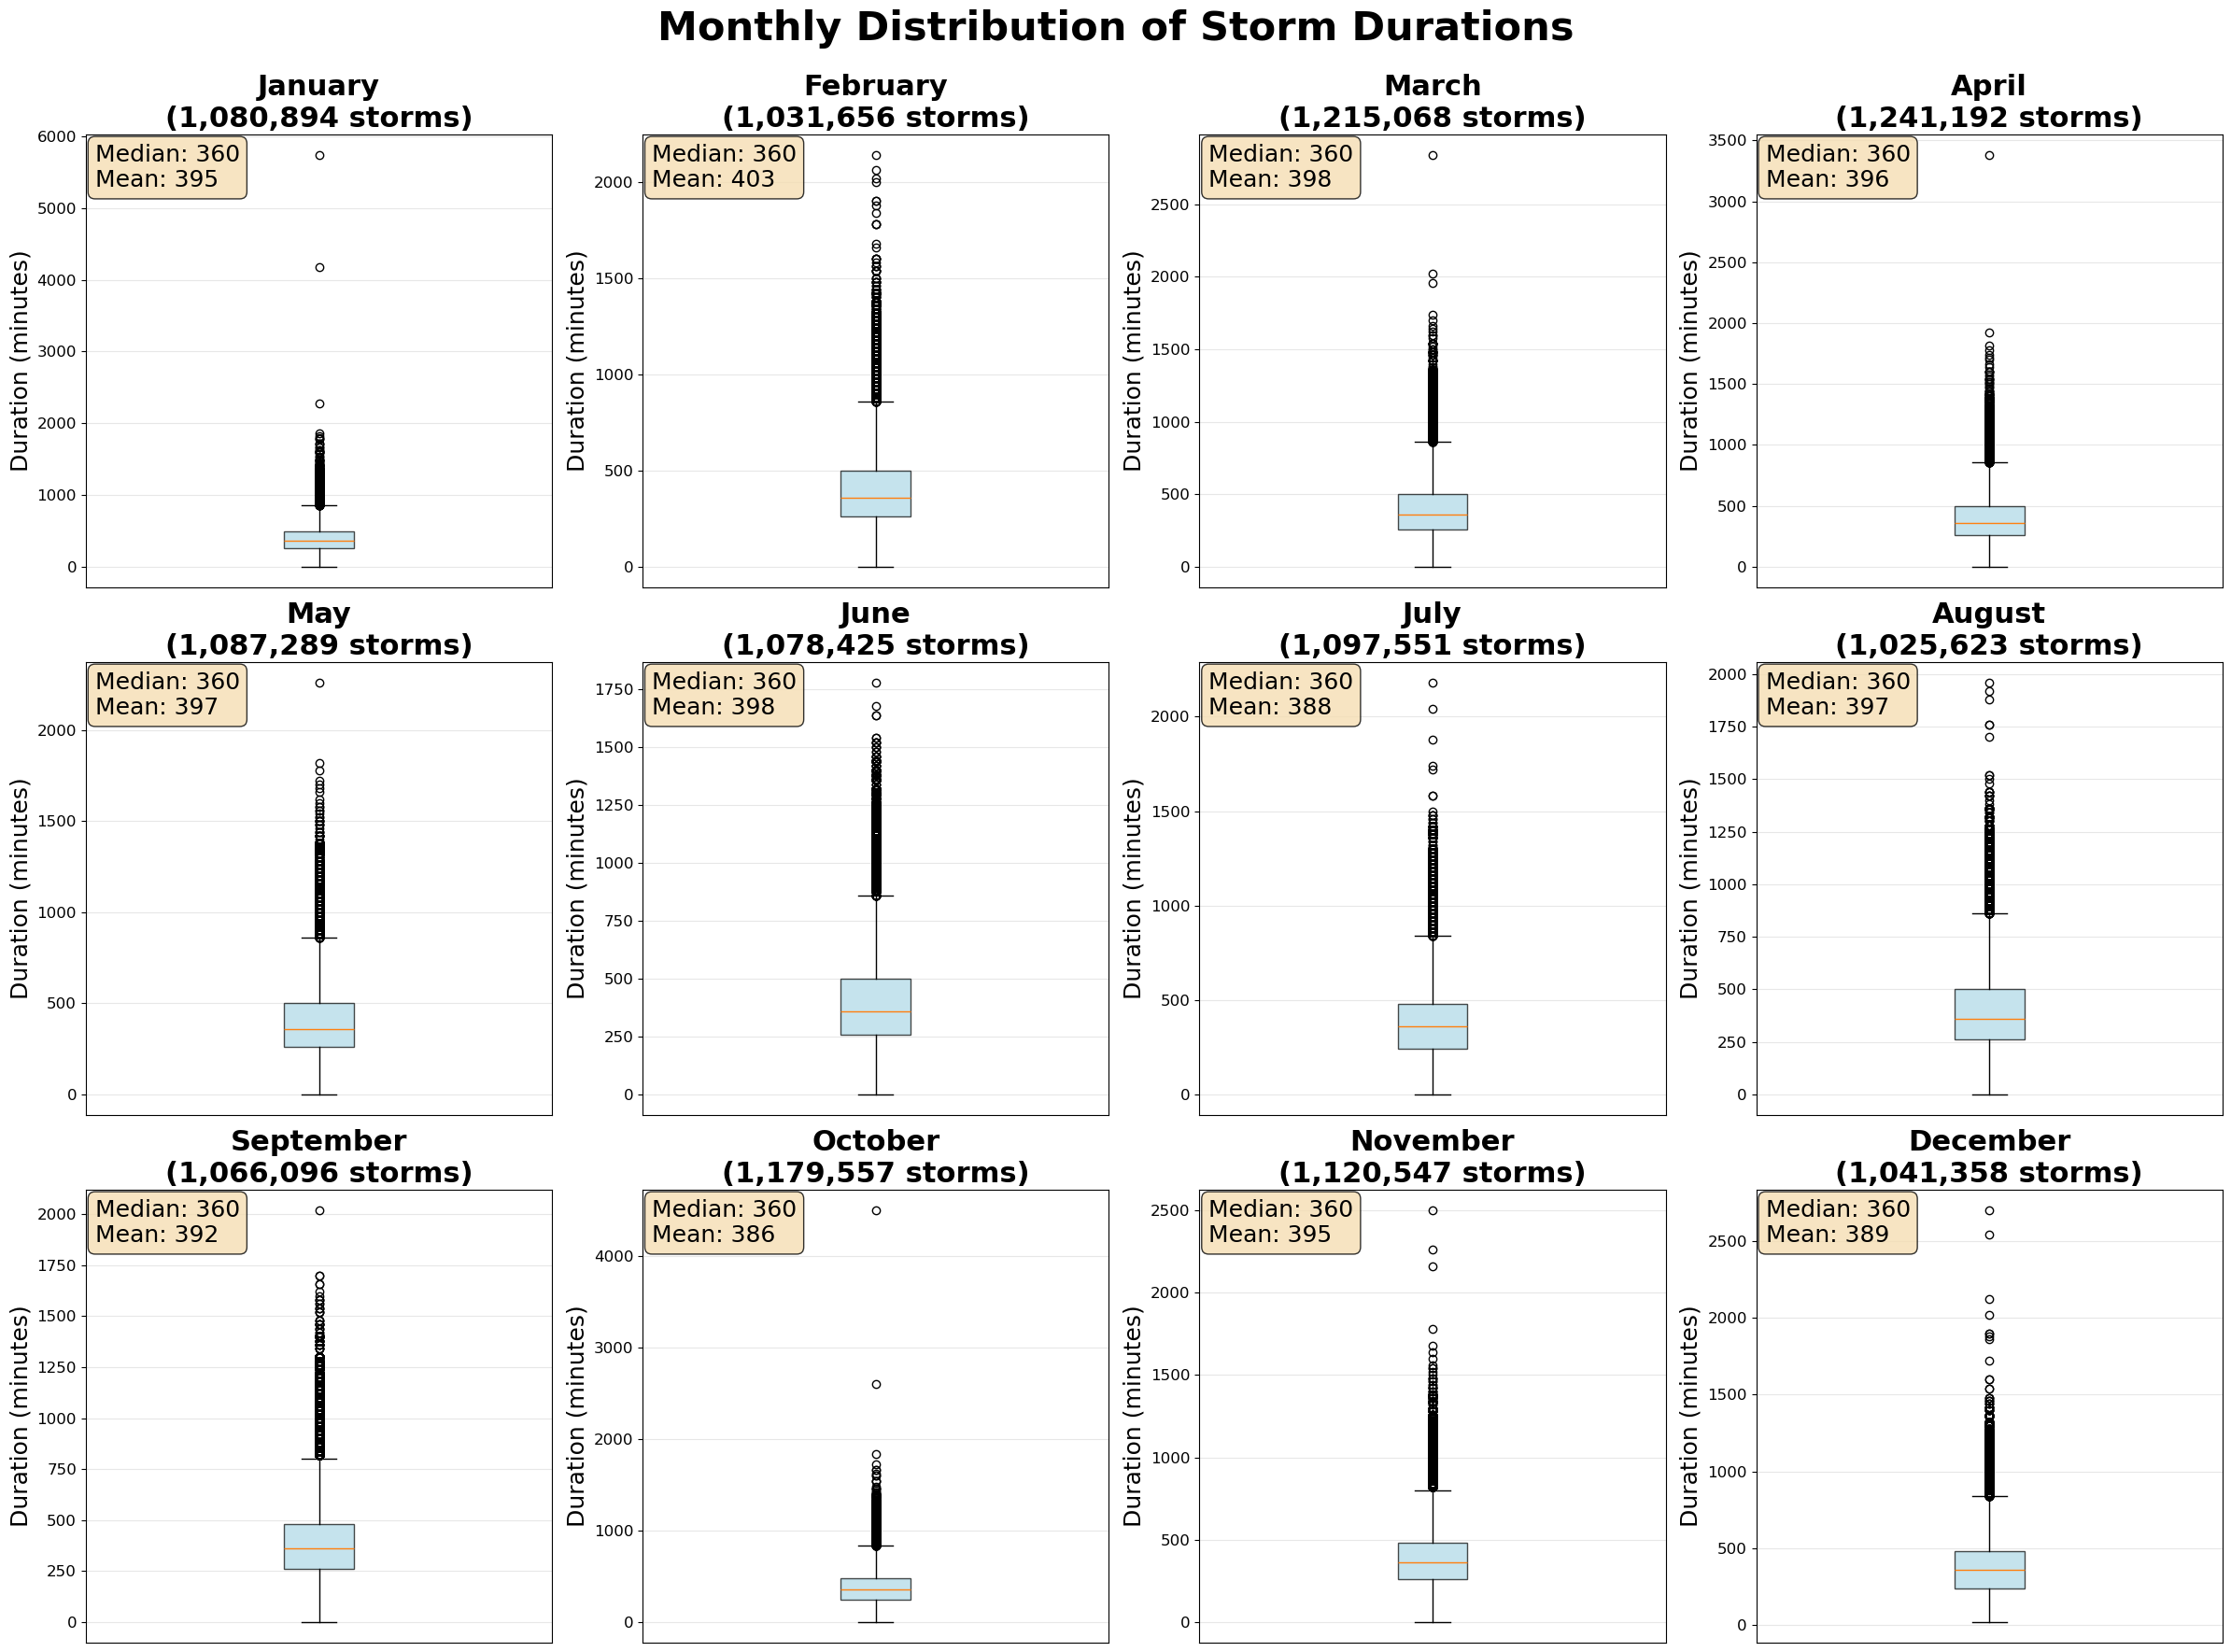

Complete!


In [3]:
# Main execution - run the complete analysis pipeline
print("Starting corrected reconstruction...")

# Step 1: Process all storm data files and reconstruct true multi-day storms
storm_data = reconstruct_storms_correctly_and_fast(data_dir)

if storm_data is not None:
    print("\nCreating box plots...")
    
    # Step 2: Create monthly visualization of storm durations
    fig = create_monthly_boxplots(storm_data, 'true_duration_min')
    
    # Step 3: Save the visualization as high-quality image
    output_filename = 'monthly_storm_duration_boxplots.png'
    fig.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Box plots saved as: {output_filename}")
    
    # Step 4: Display the results
    plt.show()
    print("Complete!")
else:
    print("Failed to process data.")